# Import Libraries

In [1]:
import multiprocessing
from joblib import Parallel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE

# Data Paths

In [2]:
!ls data/

 clients.csv		       materials.csv   transactions.parquet
'hack data description.xlsx'   plants.csv


In [3]:
clients_path = './data/clients.csv'
materials_path = './data/materials.csv'
plants_path = './data/plants.csv'
transactions_path = './data/transactions.parquet'
description_path = './data/hack data description.xlsx'

# Read Data

In [4]:
df_transactions = pd.read_parquet(transactions_path)
df_clients = pd.read_csv(clients_path)
df_materials = pd.read_csv(materials_path)
df_plants = pd.read_csv(plants_path)

In [5]:
df_transactions.shape

(32109414, 9)

## Merge Tables

In [6]:
df_transactions = pd.merge(df_transactions, df_clients, on='client_id', how='outer')
df_transactions = pd.merge(df_transactions, df_materials, on='material', how='outer')
df_transactions = pd.merge(df_transactions, df_plants, on='plant', how='outer')

In [7]:
df_transactions.shape

(32109414, 21)

In [8]:
df_transactions.head()

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,gender,...,birthyear,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,plant_type,city_y
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0,M,...,1957.0,FOOD,8e296a067a37563370ded05f5a3bf3ec,4e0223a87610176ef0d24ef6d2dcde3a,7b6ca9e5defffac176ccce54d800d4c6,a7f03c8242ae70012f1c0ebd8ad0b466,0.0,0.0,HM,St. Petersburg
1,b3d580621edab7d3831f18a958a4fb2c,7cd86ecb09aa48c6e620b340f6a74592,2016-11-09,014,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,1.0,73.49,0,M,...,1957.0,FOOD,8e296a067a37563370ded05f5a3bf3ec,4e0223a87610176ef0d24ef6d2dcde3a,7b6ca9e5defffac176ccce54d800d4c6,a7f03c8242ae70012f1c0ebd8ad0b466,0.0,0.0,HM,St. Petersburg
2,035909c0603067534edb2e4cb2be56d8,7cd86ecb09aa48c6e620b340f6a74592,2016-11-23,013,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0,M,...,1957.0,FOOD,8e296a067a37563370ded05f5a3bf3ec,4e0223a87610176ef0d24ef6d2dcde3a,7b6ca9e5defffac176ccce54d800d4c6,a7f03c8242ae70012f1c0ebd8ad0b466,0.0,0.0,HM,St. Petersburg
3,0f49930b9e077a0c0ed8cc9c5f817995,7cd86ecb09aa48c6e620b340f6a74592,2017-01-27,013,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,1.0,73.49,0,M,...,1957.0,FOOD,8e296a067a37563370ded05f5a3bf3ec,4e0223a87610176ef0d24ef6d2dcde3a,7b6ca9e5defffac176ccce54d800d4c6,a7f03c8242ae70012f1c0ebd8ad0b466,0.0,0.0,HM,St. Petersburg
4,fce9129976a1017cab47f0d735dd4fcd,7cd86ecb09aa48c6e620b340f6a74592,2017-07-27,012,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,109.98,1,M,...,1957.0,FOOD,8e296a067a37563370ded05f5a3bf3ec,4e0223a87610176ef0d24ef6d2dcde3a,7b6ca9e5defffac176ccce54d800d4c6,a7f03c8242ae70012f1c0ebd8ad0b466,0.0,0.0,HM,St. Petersburg


# Embedding of the Goods

In [25]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


def _dataframe_handler(df):
    return df.apply(lambda x: ' '.join([str(x_i) for x_i in x]), axis=1).values


class TfidfVectorizerDataFrames(TfidfVectorizer):
    def __init__(self, **kwargs):
        super().__init__(kwargs)

    def fit(self, df, y=None):
        raw_documents = _dataframe_handler(df=df)
        return super().fit(raw_documents, y)

    def fit_transform(self, df, y=None):
        raw_documents = _dataframe_handler(df=df)
        return super().fit_transform(raw_documents, y)

    def transform(self, raw_documents, copy="deprecated"):
        return super().transform(raw_documents, copy)

    def vectorize(self, df):
        raw_documents = _dataframe_handler(df=df)
        # TODO: make it parallel jobs
        return np.array([self.transform([material_i]).data for material_i in raw_documents])

# Analysis

In [18]:
# drop NaN's
df_transactions = df_transactions.dropna()

In [19]:
print('unique values')
for col in df_transactions.columns:
    print(col, ':', len(df_transactions[col].unique()))

unique values
chq_id : 2919820
plant : 388
chq_date : 366
chq_position : 459
client_id : 98091
material : 105463
sales_count : 9345
sales_sum : 172960
is_promo : 2
gender : 2
city_x : 3
birthyear : 107
hier_level_1 : 2
hier_level_2 : 60
hier_level_3 : 391
hier_level_4 : 2006
vendor : 4184
is_private_label : 2
is_alco : 2
plant_type : 2
city_y : 3


In [20]:
print('count values')
for col in df_transactions.columns:
    print('_'*25, col, '_'*25)
    print(df_transactions[col].value_counts())

count values
_________________________ chq_id _________________________
5d06e994d1c84b7c16bb50f61da8152a    244
be26faeae3ab7a98915c6c49387d57e4    225
43a3eb055a2cd3b44587a03db3204f4c    218
c68b39ff3a7f5210f17658c034a9d997    215
fc116312788e5800dcacc38c46619514    206
                                   ... 
ff320c78dba3849c1f0880f03e2b5d50      1
5bcdef5e879b018c9720507501033c6d      1
db848ca05926a58bbe04fcdca701e2e0      1
9d10e2e18368bbbd3b403c3f692e7b22      1
5768f206c95096a23a96ce83aef906d6      1
Name: chq_id, Length: 2919820, dtype: int64
_________________________ plant _________________________
95b09698fda1f64af16708ffb859eab9    431160
29549a71a57f587d88209b9c1f1b7999    390411
43692f46e3168b32434dd507ebc85dbe    285362
6950aac2d7932e1f1a4c3cf6ada1316e    275425
6858fb45a3d3aef7c29322d3b68dffd1    271872
                                     ...  
fa6fd762eab57575a037d306299c6452       952
9bb8d911c34ecdb260ff39c4de70d8b6       826
8e811a108a578f67e0024f7980d07434       716

a3d2de7675556553a5f08e4c88d2c228    1716232
555b60081984bd59d637c5f6b4aa3bdb     997934
fecaff9801e3c7f766618422d1154957     742307
e938ab3bfceabc265c9a2276a3a176b6     712239
3cdd35521f057d08781df87795f2eb19     676840
                                     ...   
f4aca3c3a618156508a1a8a69a9d28ab          1
47e1186a86a632b8969b269588e5dd35          1
201ae240724894cabe64fd96c642acf3          1
7881697a7563aa75f70838c41a8927a4          1
423ccae47326838bf095ee2cb85ed80e          1
Name: vendor, Length: 4184, dtype: int64
_________________________ is_private_label _________________________
0.0    25906528
1.0     5710763
Name: is_private_label, dtype: int64
_________________________ is_alco _________________________
0.0    30229450
1.0     1387841
Name: is_alco, dtype: int64
_________________________ plant_type _________________________
HM    28556464
SM     3060827
Name: plant_type, dtype: int64
_________________________ city_y _________________________
Other             24451710
St. Pet

# Modeling

In [21]:
# df_materials = df_materials[:10000]

#### Vectorize Material

In [22]:
df_materials

,material,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco
0,35cbdf61de9e19c8b417327aaef14c88,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,9eed45f71360b4b1e2590637467220e5,212a38db0ddcd009f1e164cc8483485c,0,0
1,c0b0bf24d4ec71da3d304f761ec555d8,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,de2eb747e0896c050905a6b635ab800a,9b0b6c7d55413ad3b67761b7b125b534,0,0
2,f0fc5e654a81a7c4b8ba8d7c26546e14,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,99cad265a1768cc2dd013f0e740300ae,8a969031832c535daf96e0c2aed8e814,9b0b6c7d55413ad3b67761b7b125b534,0,0
3,353693e64fb5f9e2d29746d7fe6edf1e,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,b58f7d184743106a8a66028b7a28937c,4c0dc012ebb679a18b244c53c6f59b5a,a3c8be149d718771e892619bd310b961,0,0
4,5d9e0b4302ce95448cae72165ff4cf5b,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,b58f7d184743106a8a66028b7a28937c,4c0dc012ebb679a18b244c53c6f59b5a,a3c8be149d718771e892619bd310b961,0,0
...,...,...,...,...,...,...,...,...
105604,feeddbacd9eed3bac85b1571ac79e40e,NONFOOD,3295c76acbf4caaed33c36b1b5fc2cb1,11704817e347269b7254e744b5e22dac,e47e165040e2914783a451509bbc8180,8ca0d8745f91fb71551be26b1ca854f4,0,0
105605,e218c4c3676927e53b95a12ffe9e721a,FOOD,02e74f10e0327ad868d138f2b4fdd6f0,df0e09d6f25a15a815563df9827f48fa,a03ddfb4b641e98de3223765162217c3,e3319f2f4767af113d82174f662f2d4e,1,1
105606,9a5e2e34d8406616f5981868b4576444,NONFOOD,fc490ca45c00b1249bbe3554a4fdf6fb,865bf46435bd84fa5d89f64cf3ba7347,e2a75db437bee7d34615fccf32d7a464,546614030cdbddcae3de351852962759,0,0
105607,d208910eb82fa1f57684f793f93521a4,NONFOOD,ea5d2f1c4608232e07d3aa3d998e5135,90365351ccc7437a1309dc64e4db32a3,ea9cffc9bd2bf8a0fb128d223f6a4282,7f1dbcf6ab15c23093508627ca12b8b1,0,0


In [26]:
vectorizer = TfidfVectorizerDataFrames()
vectorizer = vectorizer.fit(df_materials)

In [27]:
transformed_data = vectorizer.vectorize(df_materials)

In [28]:
transformed_data.shape

(105609, 6)

In [29]:
transformed_data_2d = TSNE(n_components=2, n_jobs=-1).fit_transform(transformed_data)

In [30]:
labeler = preprocessing.LabelEncoder()
color = labeler.fit_transform(df_materials['hier_level_2'])

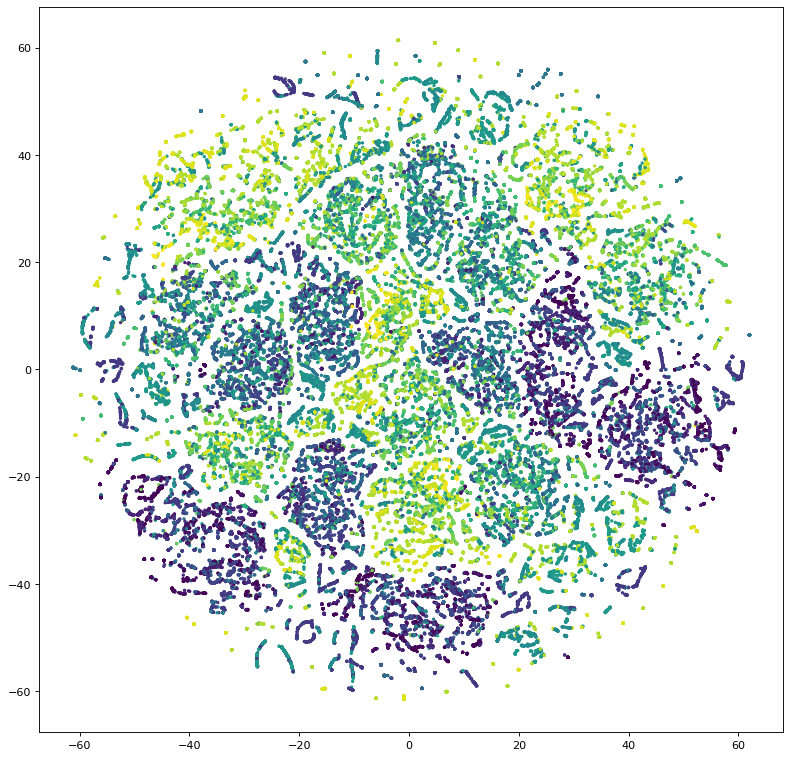

In [31]:
t = -1
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter(transformed_data_2d[:,0][:t], transformed_data_2d[:,1][:t], c=color[:t], s=4)